In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

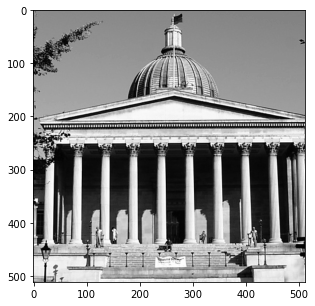

In [4]:
def show_grayscale_im(image):
  plt.figure(figsize = (5, 5))
  plt.imshow(image, cmap = "gray", vmin = 0, vmax = 1)

portico_image = cv2.imread("portico.jpg").astype(float) / 255.0
portico_image = portico_image[..., 0]
show_grayscale_im(portico_image)

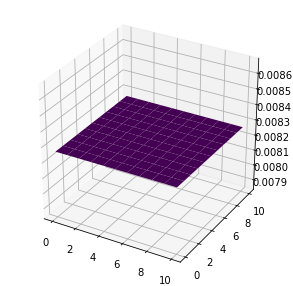

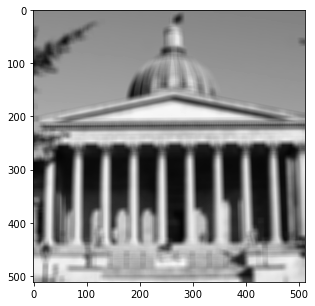

In [5]:
def plot_kernel_3d(kernel):
  plt.figure(figsize=(5, 5))
  ax = plt.axes(projection = '3d')
  x = np.ones(kernel.shape)
  y = np.ones(kernel.shape)
  for i in range(kernel.shape[0]):
    x[i, :] = i
  for i in range(kernel.shape[1]):
    y[:, i] = i
  ax.plot_surface(x, y, kernel,cmap = 'viridis', edgecolor = 'none')

box_kernel = np.ones([11, 11])
box_kernel /= box_kernel.sum()
plot_kernel_3d(box_kernel)
box_filtered_portico = cv2.filter2D(portico_image, -1, box_kernel)
show_grayscale_im(box_filtered_portico)

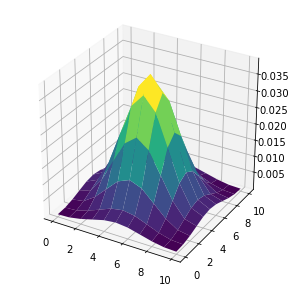

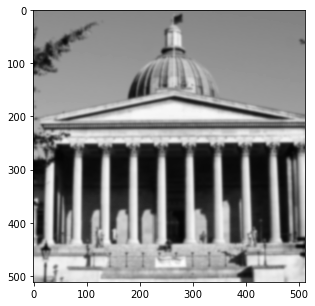

In [6]:
# Filtering with a Gaussian Kernel
#Making kernel with OpenCV (code here is not important)
gaussian_kernel = np.zeros([11, 11])
gaussian_kernel[5, 5] = 1.0
gaussian_kernel = cv2.GaussianBlur(gaussian_kernel, (11, 11), 2)
gaussian_kernel /= gaussian_kernel.sum()

#Plot kernel, filter and display output
plot_kernel_3d(gaussian_kernel)
gaussian_portico = cv2.filter2D(portico_image, -1, gaussian_kernel)
show_grayscale_im(gaussian_portico)

## Exercise: Try Other Kernels
Try to filter the portico image using this filter kernel: 

[ 0, -1, 0]

[-1, 5, -1]

[ 0, -1, 0]

and

[-1, -1, -1]

[-1, 8, -1]

[-1, -1, -1]

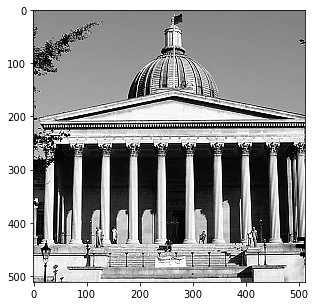

In [8]:
sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_portico = cv2.filter2D(portico_image, -1, sharpening_kernel)
show_grayscale_im(sharpened_portico)

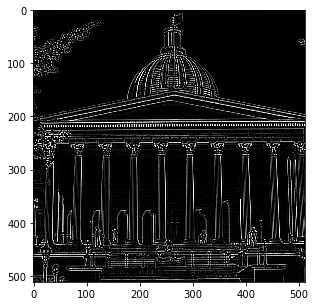

In [9]:
edge_detect_kernel = np.array([[-1,-1,-1], [-1, 8, -1], [-1, -1, -1]])
edges_portico = cv2.filter2D(portico_image, -1, edge_detect_kernel)
show_grayscale_im(edges_portico)

## Exercise: Enhancing higher frequencies
Try subtracting the gaussian filtered portico image from the original one, to get a result containing only high frequencies.

high_freq = portico_image - gaussian_filter(portico_image)

Add a multiple of this high_freq representation on to the original image:

output = portico_image + alpha*high_freq

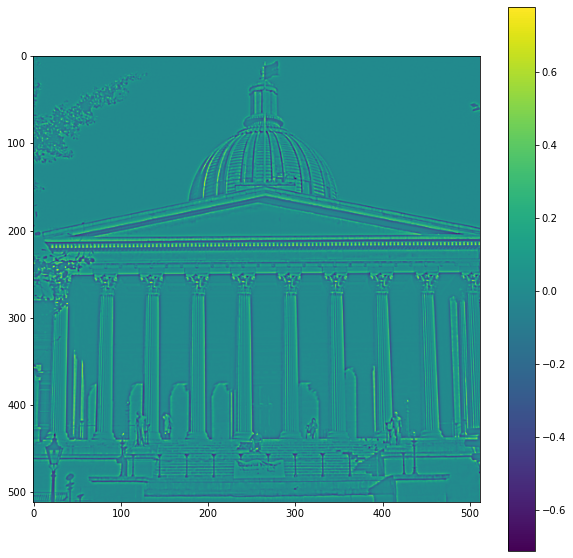

In [10]:
high_frequency_portico = portico_image - gaussian_portico
plt.figure(figsize=(10, 10))
plt.imshow(high_frequency_portico)
plt.colorbar()

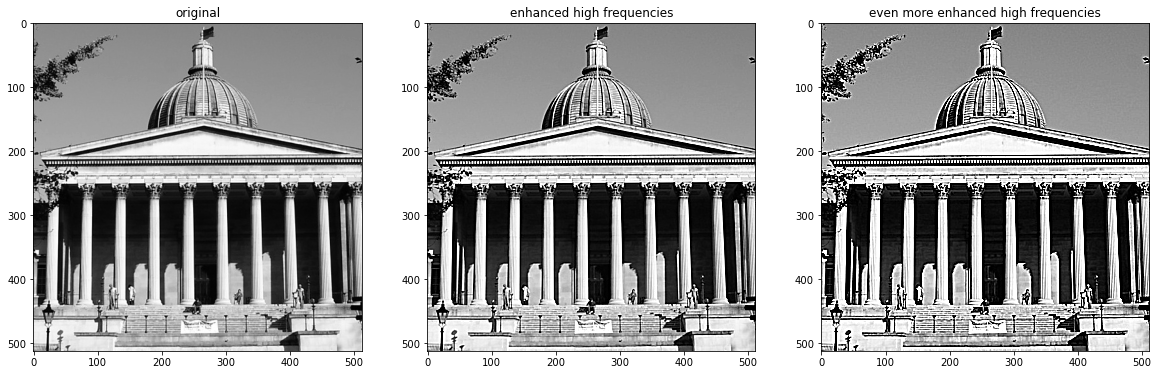

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title("original")
plt.imshow(portico_image, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 3, 2)
plt.title("enhanced high frequencies")
plt.imshow(gaussian_portico + 2.0 * high_frequency_portico, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 3, 3)
plt.title("even more enhanced high frequencies")
plt.imshow(gaussian_portico + 4.0 * high_frequency_portico, cmap = "gray", vmin = 0, vmax = 1)

The image data consists of discrete samples, so we will take the discrete fourier transform (DFT) of the image. This is computed using an algorithm called the fast fourier transform (FFT). Remember, the DFT is the approach, and the FFT is the algorithm. The fourier transform is complex-valued, so we can't plot it directly. People normally take the energy of the fourier transform and plot this (this is the square of the absolute value of the fourier transform). Also note that we use fftshift - this just rearranges the image so the low frequencies are at the centre and the high frequencies are at the edges.

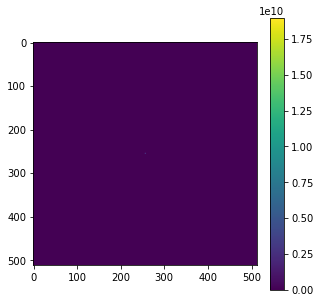

In [14]:
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(fourier_portico)**2)
plt.colorbar()

The problem is the results go over a huge range and the central pixel (lowest frequency) has a huge value. Because of this people normally plot the logarithm of the energy. We also add one to ensure that if the energy is zero, the logarithm is still valid.

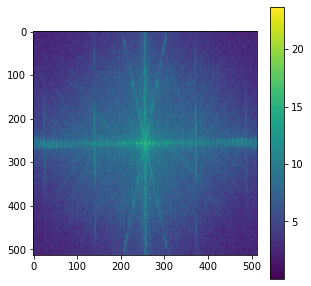

In [15]:
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
plt.figure(figsize = (5, 5))
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()

notice the result is symmetric. This is always the case when you take the fourier transform of a real signal. You can save some work by just computing half of the values (in numpy, this is the rfft function):

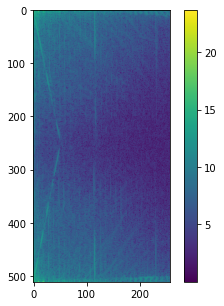

In [16]:
fourier_portico = np.fft.rfft2(portico_image)
plt.figure(figsize = (5, 5))
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()

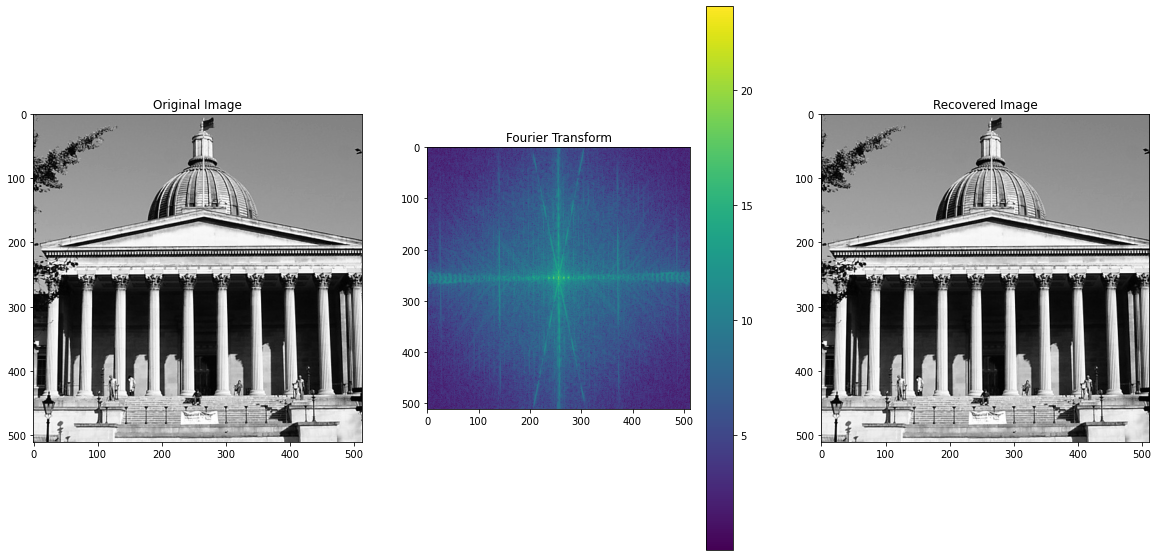

In [17]:
# Fourier transform is invertible, and can recover the original image using the inverse Fourier transform.
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
#We need np.real here because ifft2 returns complex values.
#The imaginary part of the recovered image is zero.
#Note that since we used fftshift earlier, we need to reverse it using ifftshift
recovered_image = np.real(np.fft.ifft2(np.fft.ifftshift(fourier_portico)))
plt.figure(figsize = (20,10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(portico_image, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 3, 2)
plt.title("Fourier Transform")
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Recovered Image")
plt.imshow(recovered_image, cmap = "gray", vmin = 0, vmax = 1)

One very important property of the Fourier transform is the convolution theorem. This says that convolution in the spatial domain is equivalent to (elementwise) multiplication in the fourier domain.

That is, convolve(a, b) = F^-1(F(a) * F(b))

This is very useful, as the multiplication is normally much faster than convolution, particularly if the kernel size is large.

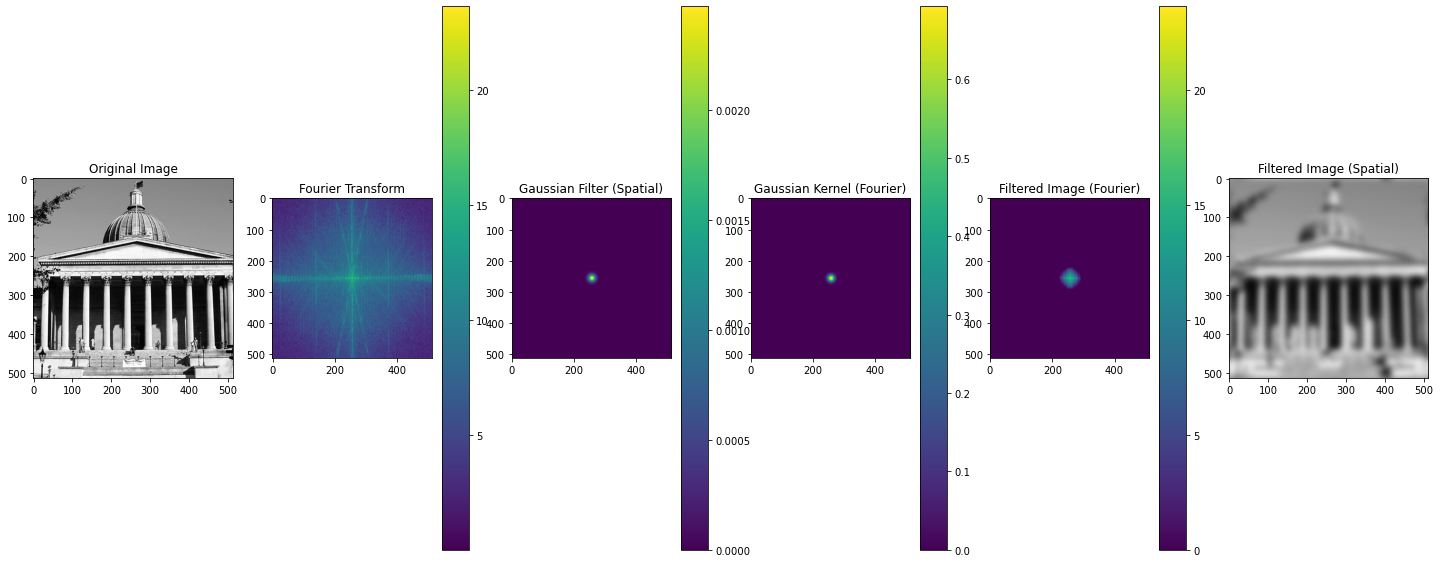

In [19]:
# Try changing this parameter of the gaussian. How does the gaussian change?
# How does its Fourier transform change?
gaussian_standard_deviation = 8

#Making kernel with OpenCV (code here is not important)
gaussian_kernel = np.zeros([512, 512])
gaussian_kernel[255:257, 255:257] = 1.0
gaussian_kernel = cv2.GaussianBlur(gaussian_kernel, (51, 51), gaussian_standard_deviation)
gaussian_kernel /= gaussian_kernel.sum()

gaussian_kernel_fourier = np.fft.fftshift(np.fft.fft2(gaussian_kernel))

fourier_portico = np.fft.fftshift(np.fft.fft2(portico_image))

filtered_fourier = fourier_portico * gaussian_kernel_fourier

filtered_spatial = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.ifftshift(filtered_fourier))))

plt.figure(figsize = (25, 10))
plt.subplot(1, 6, 1)
plt.title("Original Image")
plt.imshow(portico_image, cmap="gray", vmin=0, vmax=1)
plt.subplot(1, 6, 2)
plt.title("Fourier Transform")
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()
plt.subplot(1, 6, 3)
plt.title("Gaussian Filter (Spatial)")
plt.imshow(gaussian_kernel)
plt.colorbar()
plt.subplot(1, 6, 4)
plt.title("Gaussian Kernel (Fourier)")
plt.imshow(np.log(np.abs(gaussian_kernel_fourier)**2 + 1))
plt.colorbar()
plt.subplot(1, 6, 5)
plt.title("Filtered Image (Fourier)")
plt.imshow(np.log(np.abs(filtered_fourier)**2 + 1))
plt.colorbar()
plt.subplot(1, 6, 6)
plt.title("Filtered Image (Spatial)")
plt.imshow(filtered_spatial, cmap="gray", vmin=0, vmax=1)

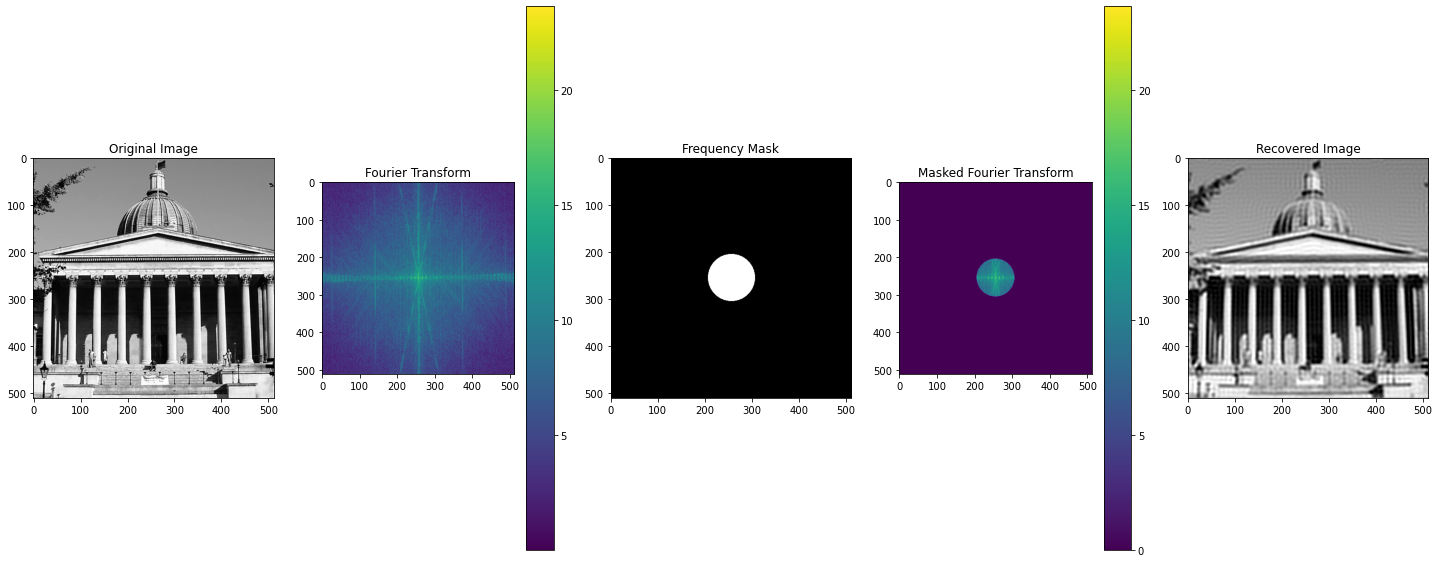

In [20]:
# Ideal Filter
fourier_portico = np.fft.fft2(portico_image)
fourier_portico = np.fft.fftshift(fourier_portico)
ideal_filter = np.zeros(portico_image.shape)

# This controls the radius of the ideal filter. Try modifying it and seeing how the result changes.
filter_radius = 50
filter_center = [255.5, 255.5]
for i in range(ideal_filter.shape[0]):
  for j in range(ideal_filter.shape[1]):
    dist = np.sqrt((i - filter_center[0])**2 + (j - filter_center[1])**2)
    if dist < filter_radius:
      ideal_filter[i, j] = 1
filtered_fourier = ideal_filter * fourier_portico
filtered_image = np.real(np.fft.ifft2(np.fft.fftshift(filtered_fourier)))
plt.figure(figsize=(25, 10))
plt.subplot(1, 5, 1)
plt.title("Original Image")
plt.imshow(portico_image, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 5, 2)
plt.title("Fourier Transform")
plt.imshow(np.log(np.abs(fourier_portico)**2 + 1))
plt.colorbar()
plt.subplot(1, 5, 3)
plt.title("Frequency Mask")
plt.imshow(ideal_filter, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 5, 4)
plt.title("Masked Fourier Transform")
plt.imshow(np.log(np.abs(filtered_fourier)**2 + 1))
plt.colorbar()
plt.subplot(1, 5, 5)
plt.title("Recovered Image")
plt.imshow(filtered_image, cmap = "gray", vmin = 0, vmax = 1)

The result is definitely blurred, but has some strange artefacts:

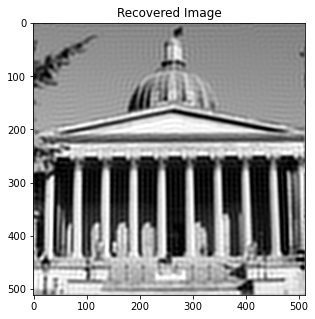

In [21]:
plt.figure(figsize = (5, 5))
plt.title("Recovered Image")
plt.imshow(filtered_image, cmap = "gray", vmin = 0, vmax = 1)

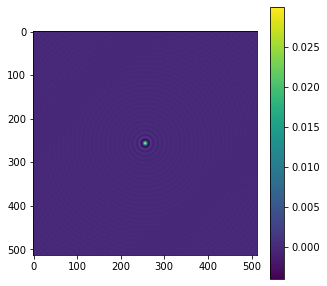

<Figure size 360x360 with 0 Axes>

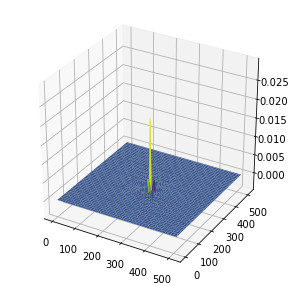

In [22]:
mask_spatial = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.ifftshift(ideal_filter))))
plt.figure(figsize = (5, 5))
plt.imshow(mask_spatial)

plt.colorbar()
plt.figure(figsize = (5, 5))
plot_kernel_3d(mask_spatial)

In the spatial domain, this hard-edged filter is converted into a filter which oscillates. This is a common property of hard-edged frequency-domain filters, which are called "ideal filters" or "brick wall filters". In general such filters become sinc filters in the spatial domain (https://en.wikipedia.org/wiki/Sinc_filter)